# Introduction

This example shows how to do image classification from scratch, starting from JPEG image files on disk, without leveraging pre-trained weights or a pre-made Keras Application model. We demonstrate the workflow on the Kaggle Cats vs Dogs binary classification dataset.

We use the image_dataset_from_directory utility to generate the datasets, and we use Keras image preprocessing layers for image standardization and data augmentation.

- [Keras Documentation](https://keras.io/examples/vision/image_classification_from_scratch/)


# Setup

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Load the data: the Cats vs Dogs dataset

In [2]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

curl: /opt/conda/lib/libcurl.so.4: no version information available (required by curl)
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   242M      0  0:00:03  0:00:03 --:--:--  242M


In [3]:
!unzip -q kagglecatsanddogs_5340.zip
!ls

 CDLA-Permissive-2.0.pdf   __notebook__.ipynb	       'readme[1].txt'
 PetImages		   kagglecatsanddogs_5340.zip


In [4]:
!ls PetImages

Cat  Dog


In [5]:
!ls PetImages -1 | wc -l

2


In [6]:
!ls PetImages/Cat -1 | wc -l

12501


In [7]:
!ls PetImages/Dog -1 | wc -l

12501


# Filter out corrupted images

In [8]:
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 1590 images


In [9]:
!ls PetImages/Cat -1 | wc -l

11742


In [10]:
!ls PetImages/Dog -1 | wc -l

11670


# Generate a Dataset

In [11]:
image_size = (180, 180)
batch_size = 32

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="both",
    seed=123456,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Using 4682 files for validation.


# Visualize the data

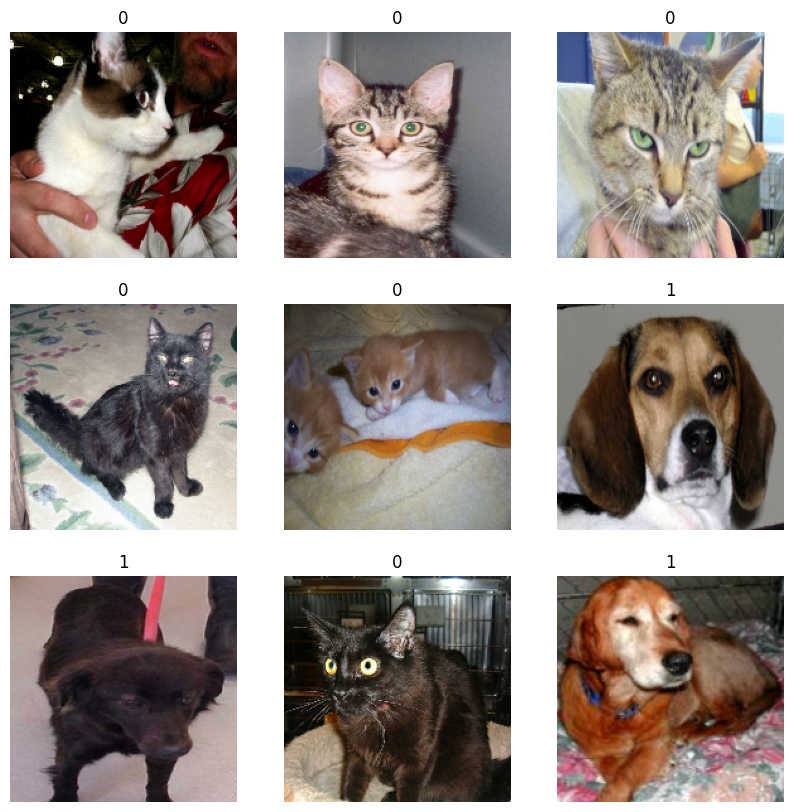

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

# Using image data augmentation

In [13]:
AUG = {
    # AUGMENTATION
    'AUGMENTATION_RANDOM_FLIP': 'horizontal',
    'AUGMENTATION_RANDOM_ROTATION':0.5,
    'AUGMENTATION_RANDOM_ZOOM':0.2,
    'AUGMENTATION_RESCALING': 1./255,
    'AUGMENTATION_RANDOM_CONTRAST_FACTOR':0.2,
    'AUGMENTATION_RANDOM_TRANSLATION_HEIGHT_FACTOR':0.1, 
    'AUGMENTATION_RANDOM_TRANSLATION_WIDTH_FACTOR':0.1, 
    'AUGMENTATION_RANDOM_TRANSLATION_FILL_MODE':'reflect', 
    'AUGMENTATION_RANDOM_TRANSLATION_INTERPOLATION':'bilinear',
    'DIRECTORY_SEED': 123456,
}

In [14]:
AUGMENTATION = keras.Sequential(
  [
    layers.RandomFlip(
        AUG['AUGMENTATION_RANDOM_FLIP']
    ),
    layers.RandomRotation(
        AUG['AUGMENTATION_RANDOM_ROTATION']
    ),
    layers.RandomZoom(
        AUG['AUGMENTATION_RANDOM_ZOOM']
    ),
    layers.RandomContrast(
        factor=AUG['AUGMENTATION_RANDOM_CONTRAST_FACTOR'],
        seed=AUG['DIRECTORY_SEED']
    ),
    layers.RandomTranslation(
        height_factor=AUG['AUGMENTATION_RANDOM_TRANSLATION_HEIGHT_FACTOR'],
        width_factor=AUG['AUGMENTATION_RANDOM_TRANSLATION_WIDTH_FACTOR'],
        fill_mode=AUG['AUGMENTATION_RANDOM_TRANSLATION_FILL_MODE'],
        interpolation=AUG['AUGMENTATION_RANDOM_TRANSLATION_INTERPOLATION'],
        seed=AUG['DIRECTORY_SEED'],
    ),
  ]
)

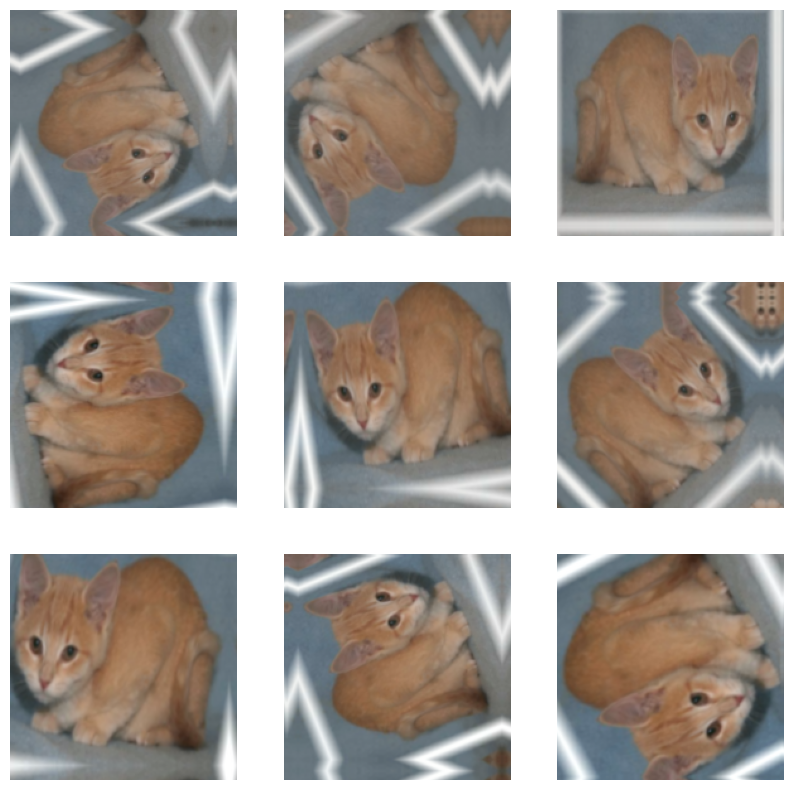

In [15]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = AUGMENTATION(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [16]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (AUGMENTATION(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

# Build a model

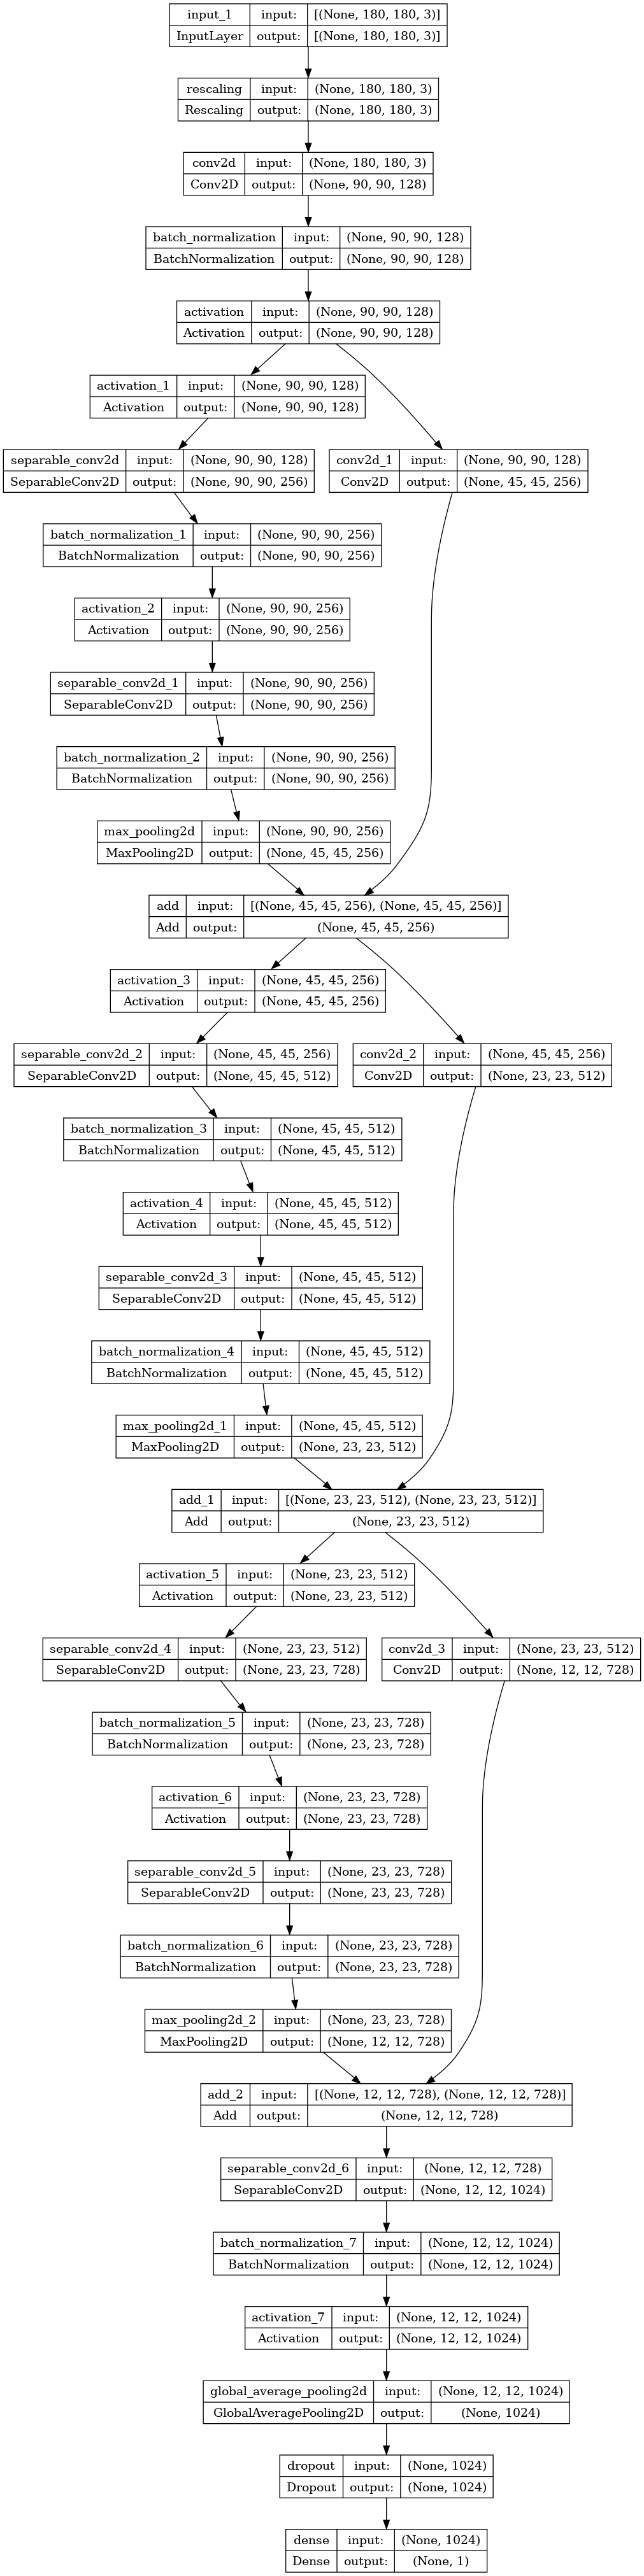

In [17]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

# Train the model

In [18]:
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/25
  4/586 [..............................] - ETA: 2:42 - loss: 0.9744 - accuracy: 0.5078

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 36/586 [>.............................] - ETA: 2:34 - loss: 0.7838 - accuracy: 0.5382

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


133/586 [=====>........................] - ETA: 2:08 - loss: 0.7338 - accuracy: 0.5566

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


273/586 [============>.................] - ETA: 1:30 - loss: 0.7134 - accuracy: 0.5703

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


360/586 [=================>............] - ETA: 1:05 - loss: 0.7049 - accuracy: 0.5761

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


473/586 [=======================>......] - ETA: 32s - loss: 0.7000 - accuracy: 0.5797

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


479/586 [=======================>......] - ETA: 31s - loss: 0.6993 - accuracy: 0.5800

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


493/586 [========================>.....] - ETA: 26s - loss: 0.6978 - accuracy: 0.5811

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


514/586 [=========================>....] - ETA: 20s - loss: 0.6945 - accuracy: 0.5842

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.6894 - accuracy: 0.5903

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


586/586 [==============================] - 208s 318ms/step - loss: 0.6894 - accuracy: 0.5903 - val_loss: 0.6756 - val_accuracy: 0.5735
Epoch 2/25
  4/586 [..............................] - ETA: 2:52 - loss: 0.6247 - accuracy: 0.6797

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 36/586 [>.............................] - ETA: 2:43 - loss: 0.6432 - accuracy: 0.6354

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


133/586 [=====>........................] - ETA: 2:15 - loss: 0.6482 - accuracy: 0.6302

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


273/586 [============>.................] - ETA: 1:33 - loss: 0.6333 - accuracy: 0.6487

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


360/586 [=================>............] - ETA: 1:07 - loss: 0.6295 - accuracy: 0.6510

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


473/586 [=======================>......] - ETA: 33s - loss: 0.6277 - accuracy: 0.6520

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


479/586 [=======================>......] - ETA: 31s - loss: 0.6274 - accuracy: 0.6523

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


493/586 [========================>.....] - ETA: 27s - loss: 0.6260 - accuracy: 0.6531

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


514/586 [=========================>....] - ETA: 21s - loss: 0.6254 - accuracy: 0.6541

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.6213 - accuracy: 0.6580

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


586/586 [==============================] - 188s 321ms/step - loss: 0.6213 - accuracy: 0.6580 - val_loss: 0.7660 - val_accuracy: 0.5737
Epoch 3/25
  4/586 [..............................] - ETA: 2:54 - loss: 0.6299 - accuracy: 0.6484

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 36/586 [>.............................] - ETA: 2:45 - loss: 0.5873 - accuracy: 0.6858

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


133/586 [=====>........................] - ETA: 2:15 - loss: 0.5800 - accuracy: 0.6976

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


273/586 [============>.................] - ETA: 1:33 - loss: 0.5784 - accuracy: 0.7007

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


360/586 [=================>............] - ETA: 1:07 - loss: 0.5742 - accuracy: 0.7043

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


473/586 [=======================>......] - ETA: 33s - loss: 0.5743 - accuracy: 0.7022

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


479/586 [=======================>......] - ETA: 32s - loss: 0.5747 - accuracy: 0.7016

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


493/586 [========================>.....] - ETA: 27s - loss: 0.5748 - accuracy: 0.7016

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


514/586 [=========================>....] - ETA: 21s - loss: 0.5733 - accuracy: 0.7034

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.5713 - accuracy: 0.7047

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


586/586 [==============================] - 189s 322ms/step - loss: 0.5713 - accuracy: 0.7047 - val_loss: 0.6074 - val_accuracy: 0.6504
Epoch 4/25
  4/586 [..............................] - ETA: 2:53 - loss: 0.5458 - accuracy: 0.7266

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 36/586 [>.............................] - ETA: 2:46 - loss: 0.5343 - accuracy: 0.7240

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


133/586 [=====>........................] - ETA: 2:16 - loss: 0.5407 - accuracy: 0.7265

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


273/586 [============>.................] - ETA: 1:33 - loss: 0.5333 - accuracy: 0.7332

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


360/586 [=================>............] - ETA: 1:07 - loss: 0.5279 - accuracy: 0.7382

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


473/586 [=======================>......] - ETA: 33s - loss: 0.5293 - accuracy: 0.7375

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


479/586 [=======================>......] - ETA: 32s - loss: 0.5289 - accuracy: 0.7375

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


493/586 [========================>.....] - ETA: 27s - loss: 0.5280 - accuracy: 0.7382

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


514/586 [=========================>....] - ETA: 21s - loss: 0.5251 - accuracy: 0.7395

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.5218 - accuracy: 0.7413

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


586/586 [==============================] - 189s 322ms/step - loss: 0.5218 - accuracy: 0.7413 - val_loss: 0.9200 - val_accuracy: 0.5854
Epoch 5/25
  4/586 [..............................] - ETA: 2:54 - loss: 0.4870 - accuracy: 0.7109

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 36/586 [>.............................] - ETA: 2:45 - loss: 0.4915 - accuracy: 0.7422

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


133/586 [=====>........................] - ETA: 2:16 - loss: 0.4846 - accuracy: 0.7627

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


273/586 [============>.................] - ETA: 1:34 - loss: 0.4669 - accuracy: 0.7816

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


360/586 [=================>............] - ETA: 1:07 - loss: 0.4622 - accuracy: 0.7830

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


473/586 [=======================>......] - ETA: 33s - loss: 0.4644 - accuracy: 0.7814

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


479/586 [=======================>......] - ETA: 32s - loss: 0.4636 - accuracy: 0.7820

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


493/586 [========================>.....] - ETA: 27s - loss: 0.4634 - accuracy: 0.7813

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


514/586 [=========================>....] - ETA: 21s - loss: 0.4630 - accuracy: 0.7811

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.4633 - accuracy: 0.7816

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


586/586 [==============================] - 189s 322ms/step - loss: 0.4633 - accuracy: 0.7816 - val_loss: 0.8055 - val_accuracy: 0.5583
Epoch 6/25
  4/586 [..............................] - ETA: 2:55 - loss: 0.3848 - accuracy: 0.8281

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 36/586 [>.............................] - ETA: 2:45 - loss: 0.3838 - accuracy: 0.8281

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


134/586 [=====>........................] - ETA: 2:15 - loss: 0.4122 - accuracy: 0.8067

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


273/586 [============>.................] - ETA: 1:34 - loss: 0.4118 - accuracy: 0.8077

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


360/586 [=================>............] - ETA: 1:07 - loss: 0.4096 - accuracy: 0.8093

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


473/586 [=======================>......] - ETA: 33s - loss: 0.4113 - accuracy: 0.8082

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


479/586 [=======================>......] - ETA: 32s - loss: 0.4117 - accuracy: 0.8077

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


493/586 [========================>.....] - ETA: 27s - loss: 0.4109 - accuracy: 0.8082

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


514/586 [=========================>....] - ETA: 21s - loss: 0.4108 - accuracy: 0.8083

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.4098 - accuracy: 0.8091

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


586/586 [==============================] - 189s 322ms/step - loss: 0.4098 - accuracy: 0.8091 - val_loss: 0.5943 - val_accuracy: 0.7059
Epoch 7/25
  4/586 [..............................] - ETA: 2:55 - loss: 0.4433 - accuracy: 0.7891

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 36/586 [>.............................] - ETA: 2:46 - loss: 0.3618 - accuracy: 0.8394

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


133/586 [=====>........................] - ETA: 2:16 - loss: 0.3695 - accuracy: 0.8289

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


273/586 [============>.................] - ETA: 1:33 - loss: 0.3734 - accuracy: 0.8262

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


360/586 [=================>............] - ETA: 1:07 - loss: 0.3746 - accuracy: 0.8286

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


473/586 [=======================>......] - ETA: 33s - loss: 0.3744 - accuracy: 0.8292

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


479/586 [=======================>......] - ETA: 32s - loss: 0.3744 - accuracy: 0.8293

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


493/586 [========================>.....] - ETA: 27s - loss: 0.3748 - accuracy: 0.8291

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


514/586 [=========================>....] - ETA: 21s - loss: 0.3752 - accuracy: 0.8293

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.3755 - accuracy: 0.8293

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


586/586 [==============================] - 189s 322ms/step - loss: 0.3755 - accuracy: 0.8293 - val_loss: 0.3763 - val_accuracy: 0.8381
Epoch 8/25
  4/586 [..............................] - ETA: 2:53 - loss: 0.3408 - accuracy: 0.8672

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 36/586 [>.............................] - ETA: 2:45 - loss: 0.3453 - accuracy: 0.8542

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


133/586 [=====>........................] - ETA: 2:16 - loss: 0.3535 - accuracy: 0.8449

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


273/586 [============>.................] - ETA: 1:34 - loss: 0.3492 - accuracy: 0.8451

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


360/586 [=================>............] - ETA: 1:07 - loss: 0.3484 - accuracy: 0.8457

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


473/586 [=======================>......] - ETA: 33s - loss: 0.3485 - accuracy: 0.8452

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


479/586 [=======================>......] - ETA: 32s - loss: 0.3490 - accuracy: 0.8448

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


493/586 [========================>.....] - ETA: 27s - loss: 0.3485 - accuracy: 0.8451

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


514/586 [=========================>....] - ETA: 21s - loss: 0.3483 - accuracy: 0.8448

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.3499 - accuracy: 0.8434

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


586/586 [==============================] - 190s 322ms/step - loss: 0.3499 - accuracy: 0.8434 - val_loss: 0.4945 - val_accuracy: 0.7493
Epoch 9/25
  4/586 [..............................] - ETA: 2:56 - loss: 0.2465 - accuracy: 0.8906

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 36/586 [>.............................] - ETA: 2:45 - loss: 0.3172 - accuracy: 0.8594

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


133/586 [=====>........................] - ETA: 2:15 - loss: 0.3213 - accuracy: 0.8593

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


273/586 [============>.................] - ETA: 1:33 - loss: 0.3297 - accuracy: 0.8555

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


360/586 [=================>............] - ETA: 1:07 - loss: 0.3301 - accuracy: 0.8551

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


473/586 [=======================>......] - ETA: 33s - loss: 0.3301 - accuracy: 0.8560

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


479/586 [=======================>......] - ETA: 32s - loss: 0.3309 - accuracy: 0.8555

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


493/586 [========================>.....] - ETA: 27s - loss: 0.3312 - accuracy: 0.8550

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


514/586 [=========================>....] - ETA: 21s - loss: 0.3308 - accuracy: 0.8551

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.3304 - accuracy: 0.8550

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


586/586 [==============================] - 189s 322ms/step - loss: 0.3304 - accuracy: 0.8550 - val_loss: 0.4271 - val_accuracy: 0.8041
Epoch 10/25
  4/586 [..............................] - ETA: 2:53 - loss: 0.4015 - accuracy: 0.8281

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 36/586 [>.............................] - ETA: 2:45 - loss: 0.3064 - accuracy: 0.8672

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


133/586 [=====>........................] - ETA: 2:15 - loss: 0.3080 - accuracy: 0.8658

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


273/586 [============>.................] - ETA: 1:33 - loss: 0.3185 - accuracy: 0.8621

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


360/586 [=================>............] - ETA: 1:07 - loss: 0.3162 - accuracy: 0.8628

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


473/586 [=======================>......] - ETA: 33s - loss: 0.3162 - accuracy: 0.8632

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


479/586 [=======================>......] - ETA: 32s - loss: 0.3161 - accuracy: 0.8630

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


493/586 [========================>.....] - ETA: 27s - loss: 0.3147 - accuracy: 0.8637

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


514/586 [=========================>....] - ETA: 21s - loss: 0.3152 - accuracy: 0.8633

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.3151 - accuracy: 0.8630

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


586/586 [==============================] - 189s 322ms/step - loss: 0.3151 - accuracy: 0.8630 - val_loss: 0.3975 - val_accuracy: 0.8326
Epoch 11/25
  4/586 [..............................] - ETA: 2:53 - loss: 0.2646 - accuracy: 0.8984

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 36/586 [>.............................] - ETA: 2:44 - loss: 0.2603 - accuracy: 0.8863

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


133/586 [=====>........................] - ETA: 2:15 - loss: 0.2911 - accuracy: 0.8741

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


273/586 [============>.................] - ETA: 1:33 - loss: 0.2944 - accuracy: 0.8710

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


360/586 [=================>............] - ETA: 1:07 - loss: 0.2944 - accuracy: 0.8693

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


473/586 [=======================>......] - ETA: 33s - loss: 0.2978 - accuracy: 0.8695

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


480/586 [=======================>......] - ETA: 31s - loss: 0.2981 - accuracy: 0.8694

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


493/586 [========================>.....] - ETA: 27s - loss: 0.2968 - accuracy: 0.8699

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


514/586 [=========================>....] - ETA: 21s - loss: 0.2968 - accuracy: 0.8697

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.2969 - accuracy: 0.8692

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


586/586 [==============================] - 189s 321ms/step - loss: 0.2969 - accuracy: 0.8692 - val_loss: 0.3353 - val_accuracy: 0.8522
Epoch 12/25
  4/586 [..............................] - ETA: 2:54 - loss: 0.3265 - accuracy: 0.8359

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 36/586 [>.............................] - ETA: 2:44 - loss: 0.2789 - accuracy: 0.8759

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


133/586 [=====>........................] - ETA: 2:15 - loss: 0.2897 - accuracy: 0.8816

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


273/586 [============>.................] - ETA: 1:33 - loss: 0.2826 - accuracy: 0.8822

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


360/586 [=================>............] - ETA: 1:07 - loss: 0.2845 - accuracy: 0.8799

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


473/586 [=======================>......] - ETA: 33s - loss: 0.2876 - accuracy: 0.8782

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


479/586 [=======================>......] - ETA: 32s - loss: 0.2867 - accuracy: 0.8783

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


493/586 [========================>.....] - ETA: 27s - loss: 0.2853 - accuracy: 0.8785

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


514/586 [=========================>....] - ETA: 21s - loss: 0.2838 - accuracy: 0.8790

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.2835 - accuracy: 0.8795

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


586/586 [==============================] - 189s 322ms/step - loss: 0.2835 - accuracy: 0.8795 - val_loss: 0.3034 - val_accuracy: 0.8526
Epoch 13/25
  4/586 [..............................] - ETA: 2:53 - loss: 0.2264 - accuracy: 0.8984

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 36/586 [>.............................] - ETA: 2:44 - loss: 0.2526 - accuracy: 0.8889

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


133/586 [=====>........................] - ETA: 2:15 - loss: 0.2676 - accuracy: 0.8839

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


273/586 [============>.................] - ETA: 1:33 - loss: 0.2762 - accuracy: 0.8821

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


360/586 [=================>............] - ETA: 1:07 - loss: 0.2712 - accuracy: 0.8837

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


473/586 [=======================>......] - ETA: 33s - loss: 0.2742 - accuracy: 0.8834

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


479/586 [=======================>......] - ETA: 32s - loss: 0.2741 - accuracy: 0.8833

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


493/586 [========================>.....] - ETA: 27s - loss: 0.2733 - accuracy: 0.8836

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


514/586 [=========================>....] - ETA: 21s - loss: 0.2726 - accuracy: 0.8835

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.2717 - accuracy: 0.8834

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


586/586 [==============================] - 189s 322ms/step - loss: 0.2717 - accuracy: 0.8834 - val_loss: 0.2764 - val_accuracy: 0.8823
Epoch 14/25
  4/586 [..............................] - ETA: 2:57 - loss: 0.2242 - accuracy: 0.9062

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 36/586 [>.............................] - ETA: 2:44 - loss: 0.2124 - accuracy: 0.9115

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


134/586 [=====>........................] - ETA: 2:15 - loss: 0.2519 - accuracy: 0.8932

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


273/586 [============>.................] - ETA: 1:33 - loss: 0.2649 - accuracy: 0.8866

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


360/586 [=================>............] - ETA: 1:07 - loss: 0.2641 - accuracy: 0.8871

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


473/586 [=======================>......] - ETA: 33s - loss: 0.2612 - accuracy: 0.8877

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


479/586 [=======================>......] - ETA: 32s - loss: 0.2612 - accuracy: 0.8875

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


493/586 [========================>.....] - ETA: 27s - loss: 0.2609 - accuracy: 0.8879

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


514/586 [=========================>....] - ETA: 21s - loss: 0.2607 - accuracy: 0.8884

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.2614 - accuracy: 0.8877

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


586/586 [==============================] - 189s 321ms/step - loss: 0.2614 - accuracy: 0.8877 - val_loss: 0.3088 - val_accuracy: 0.8629
Epoch 15/25
  4/586 [..............................] - ETA: 2:54 - loss: 0.2457 - accuracy: 0.9141

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 36/586 [>.............................] - ETA: 2:43 - loss: 0.2342 - accuracy: 0.8941

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


133/586 [=====>........................] - ETA: 2:15 - loss: 0.2540 - accuracy: 0.8870

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


273/586 [============>.................] - ETA: 1:33 - loss: 0.2538 - accuracy: 0.8892

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


360/586 [=================>............] - ETA: 1:07 - loss: 0.2566 - accuracy: 0.8888

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


473/586 [=======================>......] - ETA: 33s - loss: 0.2554 - accuracy: 0.8889

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


480/586 [=======================>......] - ETA: 31s - loss: 0.2548 - accuracy: 0.8892

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


493/586 [========================>.....] - ETA: 27s - loss: 0.2539 - accuracy: 0.8895

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


514/586 [=========================>....] - ETA: 21s - loss: 0.2531 - accuracy: 0.8899

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.2550 - accuracy: 0.8901

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


586/586 [==============================] - 189s 321ms/step - loss: 0.2550 - accuracy: 0.8901 - val_loss: 0.2898 - val_accuracy: 0.8740
Epoch 16/25
  3/586 [..............................] - ETA: 2:53 - loss: 0.2891 - accuracy: 0.8646

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 35/586 [>.............................] - ETA: 2:44 - loss: 0.2337 - accuracy: 0.8973

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


132/586 [=====>........................] - ETA: 2:15 - loss: 0.2417 - accuracy: 0.8939

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


272/586 [============>.................] - ETA: 1:34 - loss: 0.2463 - accuracy: 0.8950

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


359/586 [=================>............] - ETA: 1:07 - loss: 0.2492 - accuracy: 0.8948

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


472/586 [=======================>......] - ETA: 34s - loss: 0.2506 - accuracy: 0.8953

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


478/586 [=======================>......] - ETA: 32s - loss: 0.2509 - accuracy: 0.8954

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


492/586 [========================>.....] - ETA: 28s - loss: 0.2492 - accuracy: 0.8964

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


513/586 [=========================>....] - ETA: 21s - loss: 0.2490 - accuracy: 0.8961

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.2478 - accuracy: 0.8969

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


586/586 [==============================] - 190s 323ms/step - loss: 0.2478 - accuracy: 0.8969 - val_loss: 0.2977 - val_accuracy: 0.8714
Epoch 17/25
  4/586 [..............................] - ETA: 2:58 - loss: 0.2981 - accuracy: 0.8594

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 36/586 [>.............................] - ETA: 2:47 - loss: 0.1954 - accuracy: 0.9106

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


133/586 [=====>........................] - ETA: 2:17 - loss: 0.2339 - accuracy: 0.9044

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


273/586 [============>.................] - ETA: 1:35 - loss: 0.2340 - accuracy: 0.9022

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


360/586 [=================>............] - ETA: 1:08 - loss: 0.2352 - accuracy: 0.9028

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


473/586 [=======================>......] - ETA: 34s - loss: 0.2391 - accuracy: 0.9004

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


479/586 [=======================>......] - ETA: 32s - loss: 0.2387 - accuracy: 0.9005

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


493/586 [========================>.....] - ETA: 28s - loss: 0.2374 - accuracy: 0.9016

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


514/586 [=========================>....] - ETA: 21s - loss: 0.2365 - accuracy: 0.9019

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.2370 - accuracy: 0.9020

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


586/586 [==============================] - 192s 326ms/step - loss: 0.2370 - accuracy: 0.9020 - val_loss: 0.3485 - val_accuracy: 0.8612
Epoch 18/25
  4/586 [..............................] - ETA: 2:53 - loss: 0.2748 - accuracy: 0.8984

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 36/586 [>.............................] - ETA: 2:45 - loss: 0.2155 - accuracy: 0.9002

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


133/586 [=====>........................] - ETA: 2:18 - loss: 0.2228 - accuracy: 0.9062

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


273/586 [============>.................] - ETA: 1:35 - loss: 0.2323 - accuracy: 0.9029

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


360/586 [=================>............] - ETA: 1:08 - loss: 0.2337 - accuracy: 0.9024

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


473/586 [=======================>......] - ETA: 34s - loss: 0.2392 - accuracy: 0.9006

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


479/586 [=======================>......] - ETA: 32s - loss: 0.2390 - accuracy: 0.9006

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


493/586 [========================>.....] - ETA: 28s - loss: 0.2389 - accuracy: 0.9008

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


514/586 [=========================>....] - ETA: 21s - loss: 0.2380 - accuracy: 0.9015

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.2380 - accuracy: 0.9020

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


586/586 [==============================] - 192s 326ms/step - loss: 0.2380 - accuracy: 0.9020 - val_loss: 0.2505 - val_accuracy: 0.8936
Epoch 19/25
  4/586 [..............................] - ETA: 2:58 - loss: 0.2388 - accuracy: 0.9219

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 36/586 [>.............................] - ETA: 2:47 - loss: 0.1956 - accuracy: 0.9158

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


133/586 [=====>........................] - ETA: 2:17 - loss: 0.2158 - accuracy: 0.9164

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


273/586 [============>.................] - ETA: 1:35 - loss: 0.2264 - accuracy: 0.9104

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


360/586 [=================>............] - ETA: 1:08 - loss: 0.2260 - accuracy: 0.9094

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


473/586 [=======================>......] - ETA: 34s - loss: 0.2309 - accuracy: 0.9064

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


479/586 [=======================>......] - ETA: 32s - loss: 0.2306 - accuracy: 0.9062

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


493/586 [========================>.....] - ETA: 28s - loss: 0.2307 - accuracy: 0.9057

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


514/586 [=========================>....] - ETA: 21s - loss: 0.2302 - accuracy: 0.9055

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.2256 - accuracy: 0.9073

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


586/586 [==============================] - 191s 326ms/step - loss: 0.2256 - accuracy: 0.9073 - val_loss: 0.3023 - val_accuracy: 0.8731
Epoch 20/25
  3/586 [..............................] - ETA: 2:56 - loss: 0.1829 - accuracy: 0.9375

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 35/586 [>.............................] - ETA: 2:48 - loss: 0.1928 - accuracy: 0.9241

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


132/586 [=====>........................] - ETA: 2:18 - loss: 0.2173 - accuracy: 0.9129

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


272/586 [============>.................] - ETA: 1:35 - loss: 0.2159 - accuracy: 0.9144

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


359/586 [=================>............] - ETA: 1:09 - loss: 0.2177 - accuracy: 0.9128

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


472/586 [=======================>......] - ETA: 34s - loss: 0.2196 - accuracy: 0.9113

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


478/586 [=======================>......] - ETA: 32s - loss: 0.2203 - accuracy: 0.9110

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


492/586 [========================>.....] - ETA: 28s - loss: 0.2202 - accuracy: 0.9110

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


513/586 [=========================>....] - ETA: 22s - loss: 0.2197 - accuracy: 0.9105

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.2179 - accuracy: 0.9114

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


586/586 [==============================] - 192s 326ms/step - loss: 0.2179 - accuracy: 0.9114 - val_loss: 0.3640 - val_accuracy: 0.8338
Epoch 21/25
  4/586 [..............................] - ETA: 3:00 - loss: 0.1804 - accuracy: 0.8984

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 36/586 [>.............................] - ETA: 2:47 - loss: 0.2002 - accuracy: 0.9132

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


133/586 [=====>........................] - ETA: 2:17 - loss: 0.2084 - accuracy: 0.9149

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


273/586 [============>.................] - ETA: 1:34 - loss: 0.2044 - accuracy: 0.9167

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


360/586 [=================>............] - ETA: 1:08 - loss: 0.2044 - accuracy: 0.9163

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


473/586 [=======================>......] - ETA: 34s - loss: 0.2083 - accuracy: 0.9145

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


479/586 [=======================>......] - ETA: 32s - loss: 0.2082 - accuracy: 0.9146

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


493/586 [========================>.....] - ETA: 28s - loss: 0.2100 - accuracy: 0.9136

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


514/586 [=========================>....] - ETA: 21s - loss: 0.2102 - accuracy: 0.9132

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.2094 - accuracy: 0.9134

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


586/586 [==============================] - 190s 324ms/step - loss: 0.2094 - accuracy: 0.9134 - val_loss: 0.2553 - val_accuracy: 0.8872
Epoch 22/25
  4/586 [..............................] - ETA: 3:01 - loss: 0.2094 - accuracy: 0.8906

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 36/586 [>.............................] - ETA: 2:45 - loss: 0.1769 - accuracy: 0.9280

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


133/586 [=====>........................] - ETA: 2:15 - loss: 0.2113 - accuracy: 0.9131

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


273/586 [============>.................] - ETA: 1:33 - loss: 0.2087 - accuracy: 0.9133

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


360/586 [=================>............] - ETA: 1:07 - loss: 0.2085 - accuracy: 0.9134

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


473/586 [=======================>......] - ETA: 33s - loss: 0.2119 - accuracy: 0.9126

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


479/586 [=======================>......] - ETA: 32s - loss: 0.2116 - accuracy: 0.9126

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


493/586 [========================>.....] - ETA: 27s - loss: 0.2121 - accuracy: 0.9122

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


514/586 [=========================>....] - ETA: 21s - loss: 0.2114 - accuracy: 0.9123

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.2107 - accuracy: 0.9133

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


586/586 [==============================] - 189s 322ms/step - loss: 0.2107 - accuracy: 0.9133 - val_loss: 0.3058 - val_accuracy: 0.8763
Epoch 23/25
  4/586 [..............................] - ETA: 2:55 - loss: 0.2055 - accuracy: 0.9453

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 36/586 [>.............................] - ETA: 2:45 - loss: 0.1845 - accuracy: 0.9262

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


133/586 [=====>........................] - ETA: 2:15 - loss: 0.1897 - accuracy: 0.9196

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


273/586 [============>.................] - ETA: 1:33 - loss: 0.1932 - accuracy: 0.9216

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


360/586 [=================>............] - ETA: 1:07 - loss: 0.1947 - accuracy: 0.9194

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


473/586 [=======================>......] - ETA: 33s - loss: 0.1961 - accuracy: 0.9186

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


479/586 [=======================>......] - ETA: 32s - loss: 0.1970 - accuracy: 0.9182

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


493/586 [========================>.....] - ETA: 27s - loss: 0.1968 - accuracy: 0.9181

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


514/586 [=========================>....] - ETA: 21s - loss: 0.1972 - accuracy: 0.9176

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.1985 - accuracy: 0.9164

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


586/586 [==============================] - 189s 321ms/step - loss: 0.1985 - accuracy: 0.9164 - val_loss: 0.2371 - val_accuracy: 0.8996
Epoch 24/25
  4/586 [..............................] - ETA: 2:55 - loss: 0.2026 - accuracy: 0.9297

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 36/586 [>.............................] - ETA: 2:45 - loss: 0.1926 - accuracy: 0.9271

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


133/586 [=====>........................] - ETA: 2:15 - loss: 0.1980 - accuracy: 0.9215

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


274/586 [=============>................] - ETA: 1:33 - loss: 0.1976 - accuracy: 0.9212

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


360/586 [=================>............] - ETA: 1:07 - loss: 0.1946 - accuracy: 0.9225

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


473/586 [=======================>......] - ETA: 33s - loss: 0.1958 - accuracy: 0.9212

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


479/586 [=======================>......] - ETA: 32s - loss: 0.1960 - accuracy: 0.9211

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


493/586 [========================>.....] - ETA: 27s - loss: 0.1968 - accuracy: 0.9204

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


514/586 [=========================>....] - ETA: 21s - loss: 0.1965 - accuracy: 0.9207

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.1985 - accuracy: 0.9200

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


586/586 [==============================] - 189s 321ms/step - loss: 0.1985 - accuracy: 0.9200 - val_loss: 0.2244 - val_accuracy: 0.9082
Epoch 25/25
  4/586 [..............................] - ETA: 2:54 - loss: 0.2259 - accuracy: 0.9219

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 36/586 [>.............................] - ETA: 2:45 - loss: 0.1783 - accuracy: 0.9288

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


133/586 [=====>........................] - ETA: 2:15 - loss: 0.1846 - accuracy: 0.9229

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


273/586 [============>.................] - ETA: 1:33 - loss: 0.1865 - accuracy: 0.9236

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


360/586 [=================>............] - ETA: 1:07 - loss: 0.1884 - accuracy: 0.9231

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


473/586 [=======================>......] - ETA: 33s - loss: 0.1916 - accuracy: 0.9218

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


479/586 [=======================>......] - ETA: 32s - loss: 0.1914 - accuracy: 0.9219

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


493/586 [========================>.....] - ETA: 27s - loss: 0.1917 - accuracy: 0.9215

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


514/586 [=========================>....] - ETA: 21s - loss: 0.1913 - accuracy: 0.9217

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


586/586 [==============================] - ETA: 0s - loss: 0.1913 - accuracy: 0.9219

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


586/586 [==============================] - 189s 321ms/step - loss: 0.1913 - accuracy: 0.9219 - val_loss: 0.2943 - val_accuracy: 0.8603


# Run inference on new data

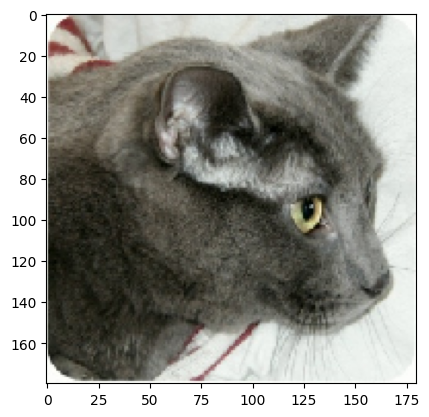

In [19]:
img = keras.utils.load_img(
    "PetImages/Cat/6779.jpg", target_size=image_size
)
plt.imshow(img)

In [20]:
img_array = keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) 

In [21]:
predictions = model.predict(img_array)
predictions

1/1 [==============================] - 1s 649ms/step


array([[0.00201801]], dtype=float32)

In [22]:
score = float(predictions[0])

In [23]:
print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")

This image is 99.80% cat and 0.20% dog.
